# cdc_diabetes_classification_acceleration_comparison

This notebook evaluates and compares four classification pipelines—vanilla scikit‑learn, Intel oneAPI acceleration, RAPIDS GPU acceleration, and a PyTorch neural network—on the CDC Diabetes Health Indicators dataset. We will measure both predictive accuracy and execution time for training and inference.


## 1. Setup and Installation
Install required libraries and extensions:
- `ucimlrepo` for fetching the UCI dataset.
- `scikit-learn-intelex` to enable Intel oneAPI optimizations in scikit-learn.


In [ ]:
!pip install ucimlrepo

In [ ]:
!pip install scikit-learn-intelex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 MB 7.8 MB/s eta 0:00:00


## 2. Imports and Configuration
Import standard Python libraries, fetch utilities, and apply oneAPI patches:


In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearnex import patch_sklearn
from sklearn.linear_model import LogisticRegression as LR_1API
from cuml.ensemble import RandomForestClassifier as cuRFC
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Apply Intel oneAPI patch to scikit-learn
patch_sklearn()

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## 3. Data Loading and Exploration
Fetch the CDC Diabetes Health Indicators dataset (ID 891) and inspect it:


In [ ]:
# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

## 4. Preprocessing
Prepare standardize inputs, and split into train/test sets:


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## 5. Model 1: Scikit-Learn Logistic Regression
Baseline logistic regression without acceleration.

In [ ]:
from sklearn.linear_model import LogisticRegression

start = time.time()
clf_sk = LogisticRegression(max_iter=500)
clf_sk.fit(X_train, y_train)
t_train_sk = time.time() - start

start = time.time()
y_pred_sk = clf_sk.predict(X_test)
t_inf_sk = time.time() - start

acc_sk = accuracy_score(y_test, y_pred_sk)
prec_sk, rec_sk, f1_sk, _ = precision_recall_fscore_support(y_test, y_pred_sk, average='binary')

print(f"sklearn — acc {acc_sk:.3f}, train {t_train_sk:.2f}s, infer {t_inf_sk:.3f}s")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sklearn — acc 0.862, train 0.22s, infer 0.005s


## 6. Model 2: Intel oneAPI-Accelerated Logistic Regression
Use Intel's extension for faster training and prediction.


In [ ]:
start = time.time()
clf_1api = LR_1API(max_iter=500)
clf_1api.fit(X_train, y_train)
t_train_1api = time.time() - start

start = time.time()
y_pred_1api = clf_1api.predict(X_test)
t_inf_1api = time.time() - start

acc_1api = accuracy_score(y_test, y_pred_1api)

print(f"oneAPI — acc {acc_1api:.3f}, train {t_train_1api:.2f}s, infer {t_inf_1api:.3f}s")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


oneAPI — acc 0.862, train 0.43s, infer 0.015s


## 7. Model 3: RAPIDS Random Forest Classifier
GPU-accelerated random forest via RAPIDS cuML.

In [ ]:
start = time.time()
cuml_model = cuRFC(n_estimators=100, random_state=42)
# Convert y_train to a 1D array or Series
cuml_model.fit(X_train, y_train['Diabetes_binary'].values)
cuml_time = time.time() - start

cuml_pred = cuml_model.predict(X_test)
cuml_inf = time.time() - start

acc_cuml = accuracy_score(y_test, cuml_pred)

print(f"oneAPI — acc {acc_cuml:.3f}, train {cuml_time:.2f}s, infer {cuml_inf:.3f}s")

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


oneAPI — acc 0.864, train 3.09s, infer 4.138s


## 8. Model 4: PyTorch Feed-Forward Neural Network
Define, train, and evaluate a simple neural network.

In [ ]:
Xt = torch.as_tensor(X_train, dtype=torch.float32)
yt = torch.as_tensor(y_train.values, dtype=torch.float32)
Xv = torch.as_tensor(X_test, dtype=torch.float32)
yv = torch.as_tensor(y_test.values, dtype=torch.float32)

train_ds = TensorDataset(Xt, yt)
train_dl = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

class Net(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1)
        )
    def forward(self, x): return self.layers(x)

torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(Xt.shape[1]).to(device)

try:
    model = torch.compile(model)
    print("Using torch.compile for acceleration")
except (AttributeError, RuntimeError):
    print("torch.compile not available, using standard model")

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

loss_fn = nn.BCEWithLogitsLoss()

val_ds = TensorDataset(Xv, yv)
val_dl = DataLoader(val_ds, batch_size=128, pin_memory=True)

epochs = 10

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    opt, max_lr=1e-3, total_steps=len(train_dl) * epochs
)

scaler = torch.cuda.amp.GradScaler()

best_acc = 0
start = time.time()

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)

        with torch.cuda.amp.autocast():
            pred = model(xb)
            loss = loss_fn(pred, yb)

        opt.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()

        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(opt)
        scaler.update()

        scheduler.step()

        train_loss += loss.item()

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds.float() == yb).sum().item()
            total += yb.size(0)

    val_acc = correct / total
    if val_acc > best_acc:
        best_acc = val_acc

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dl):.4f}, Val Acc: {val_acc:.4f}")

t_train_nn = time.time() - start

start = time.time()
model.eval()
with torch.no_grad():
    all_preds = []
    for i in range(0, len(Xv), 128):
        batch = Xv[i:i+128].to(device)
        preds = (torch.sigmoid(model(batch)) > 0.5).cpu().numpy()
        all_preds.append(preds)
    preds = np.vstack(all_preds).reshape(-1)

t_inf_nn = time.time() - start

acc_nn = accuracy_score(y_test, preds)
print(f"PyTorch NN - acc {acc_nn:.3f}, best val acc {best_acc:.3f}, train {t_train_nn:.2f}s, infer {t_inf_nn:.3f}s")


Using torch.compile for acceleration


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-7c9298d9f222>:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-11-7c9298d9f222>:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
W0511 04:51:21.356000 207 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
<ipython-input-11-7c9298d9f222>:68: Future

Epoch 1/10, Train Loss: 0.4475, Val Acc: 0.8607


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-7c9298d9f222>:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/10, Train Loss: 0.3287, Val Acc: 0.8606
Epoch 3/10, Train Loss: 0.3222, Val Acc: 0.8627
Epoch 4/10, Train Loss: 0.3206, Val Acc: 0.8635
Epoch 5/10, Train Loss: 0.3192, Val Acc: 0.8643
Epoch 6/10, Train Loss: 0.3186, Val Acc: 0.8643
Epoch 7/10, Train Loss: 0.3180, Val Acc: 0.8635
Epoch 8/10, Train Loss: 0.3181, Val Acc: 0.8642
Epoch 9/10, Train Loss: 0.3172, Val Acc: 0.8641
Epoch 10/10, Train Loss: 0.3169, Val Acc: 0.8641
PyTorch NN - acc 0.864, best val acc 0.864, train 195.15s, infer 0.169s


## 9. Results Comparison
Plot accuracy and timing across all models:

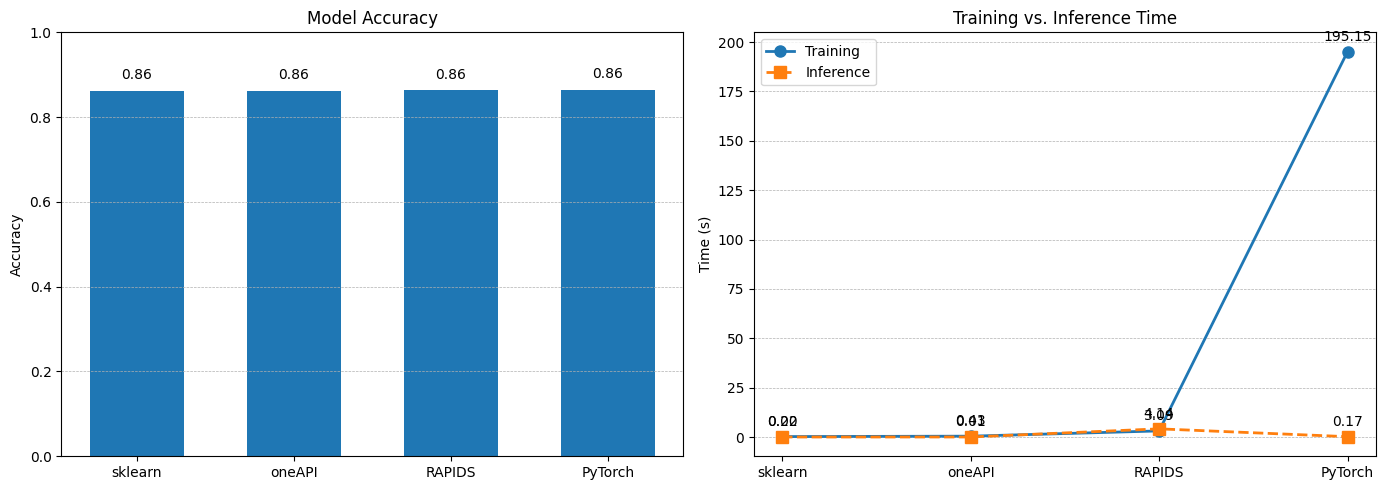

In [ ]:
models = ['sklearn', 'oneAPI', 'RAPIDS', 'PyTorch']
accs   = [acc_sk,  acc_1api, acc_cuml, acc_nn]
tr_ts  = [t_train_sk, t_train_1api, cuml_time, t_train_nn]
inf_ts = [t_inf_sk,   t_inf_1api, cuml_inf,  t_inf_nn]

# x positions
x = np.arange(len(models))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- subplot 1: Accuracy Bar Chart ---
bars = ax1.bar(x, accs, width=0.6)
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylim(0, 1)
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.grid(axis='y', linestyle='--', linewidth=0.5)

# annotate bars
for bar, val in zip(bars, accs):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.02,
             f'{val:.2f}', ha='center', va='bottom')

# --- subplot 2: Time Line Chart ---
ax2.plot(x, tr_ts, marker='o', linestyle='-', linewidth=2, markersize=8, label='Training')
ax2.plot(x, inf_ts, marker='s', linestyle='--', linewidth=2, markersize=8, label='Inference')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.set_title('Training vs. Inference Time')
ax2.set_ylabel('Time (s)')
ax2.grid(axis='y', linestyle='--', linewidth=0.5)
ax2.legend()

# annotate points
for xi, y in zip(x, tr_ts):
    ax2.text(xi, y + max(tr_ts)*0.02, f'{y:.2f}', ha='center', va='bottom')
for xi, y in zip(x, inf_ts):
    ax2.text(xi, y + max(tr_ts)*0.02, f'{y:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()